# X Revenue Forecast

<br>

### FORECASTING CYCLICAL REVENUE USING FACEBOOK PROPHET
*ADDITIVE LINEAR REGRESSION*

**Author:** Cole Fairbanks, Data Scientist

**Contact:** ccole.fairbanks@gmail.com | [LinkedIn](linkedin.com/in/colefairbanks)

**About Prophet:**  Prophet is an open source library published by Facebook that is based on decomposable (trend+seasonality+holidays) models. It provides Analysts the ability to create accurate time series forecasts and add regressors as well as the flexibility to adjust parameters like seasonality and holidays.  Prophet is especially suited for revenue and other business-oriented data that has clear seasonality and spans a few years on a monthly or weekly basis.

Regarding how Prophet was built, this alogrithm sees forecasting primarily as a curve fitting exercise using probabilistic techniques used in various well-known additive models like ARIMA. If you are interested in learning more about the mathematical components of Prophet, I suggest reading the original Prophet paper, [Forecasting at Scale](https://peerj.com/preprints/3190/), by Sean J Taylor, Benjamin Letham.

**Business Challenge:**  Company X's Finance Dept., while able to confidently predict X hardware (HW) sales two years out, has struggled to produce accurate revenue forecasts for the maintenance (MA) side of their business, which is similar to Apple Care but for legacy servers. This is a problem for Finance, as these forecasts are the basis for  long-term budgets as well as short-term business decisions.  As a Data Scientist familiar with financial data, we have been asked to forecast MA revenue for one of Company X's flagship brands, X.  The CFO is particularly interested in having reliable automated forecasts that extend beyond 6 months, with an ideal time horizon of 24 months and a consistent accuracy of 92% or above.  Fortunately, upon initial inspection, X’s historical 10-year monthly MA revenue seems to follow a predictable pattern that may allow us to deliver on the CFO's expectations.  The challenge, however, will be to factor in the relationship between HW, MA, as well as X’s unique 2-year product life cycle.

**Skills Needed to Operate:** Intermediate Python, numpy, pandas, matplotlib, basic statistics, and working knowledge of linear regression.

**Language(s):** Python

### Installing Prophet Package

### Loading Libraries

In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet.diagnostics import cross_validation, performance_metrics


### Input

This model has been optimized for 2 year forecasts, or 26 months due to the nature of Z's 2 year product life cycle and the Z HW regressor column.  However, you may choose how many months out you would like to forecast by typing in the number of desired months below:

In [2]:
months_out = 26

### Reading in CSV

In [3]:
actuals_df = pd.read_csv('historical_x_revenue.csv')

### Formating X Revenue Data Into

The format of the dataframe is very important to Prophet.  The date column, for example needs to be labeled as "ds" and contain datetime data.  In addition, the forecast model output or y must be labeled as "y".  In this case, our y values will reflect hardware maintenence revenue (HWMA).  Because Finance has also provided HW (not maintenence) revenue, we will use it within this model as a regressor, given thier inverse relationship.  There are no requirements for regressor labels and so, we will label it "hw".

In [4]:
#converting Date column to datetime type
actuals_df['Date'] = pd.to_datetime(actuals_df['Date'])

#grabbing relevant columns from dataframe
actuals_df = actuals_df[['Date','Revenue_XMA_M','Revenue_XHW_M']].reset_index(drop=True)

#renaming columns to comply with fbprophet format
actuals_df.columns = ['ds','y','hw']

#view last 5 rows of actuals_df
actuals_df.tail()

/var/folders/lp/cttcq09s3q997sn1xwstkfjh0000gn/T/ipykernel_6308/88519409.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  actuals_df['Date'] = pd.to_datetime(actuals_df['Date'])


,ds,y,hw
145,2022-02-01,43.490665,47.495255
146,2022-03-01,49.092953,279.512029
147,2022-04-01,64.041966,25.863437
148,2022-05-01,47.060985,74.087494
149,2022-06-01,50.527594,990.120315


#### Formatting Regressor - Quick Note

After speaking with product X's business leaders and conducting an initial analysis of the data, it became clear that HW sales impact MA sales roughly 26 months later, which is consistent with X's 2-year product life cycle.  According to the business, once a new product is released, old machines that have maintenence attached are replaced with newer machines that come with a 2-year warranty.  This negatively affects MA revenue.  However, after 2 years, the warranties expire and MA revenue picks up again, which we will in upcoming visualizations.

To avoid overcomplicating the notebook, I formatted the csv file so that all we need to do is shift the hardware revenue column 26 periods (months) in the future so that it correlates with the MA revenue,

In [5]:
#creating a new df that only has date and hw
hw_df = actuals_df[['ds','hw']]

#setting the index to the date
hw_df = hw_df.set_index('ds')

#shifting index 26 periods into the future
hw_df = hw_df.shift(periods=26,freq='ME')

In [6]:
#grabbing only date and ma revenue from actuals df
actuals_df = actuals_df[['ds','y']]

#setting the index to the date
actuals_df = actuals_df.set_index('ds')

#converting 1st day of month to last day of month to match hw_df
actuals_df = actuals_df.shift(periods=1,freq='ME')

#concatenating both dataframes and reassigning as actuals_df
actuals_df = pd.concat([actuals_df, hw_df], axis = 1)

#resetting index so format complies with fbprophet
actuals_df = actuals_df.reset_index(drop=False)

In [7]:
#converting all 0s to None
actuals_df.loc[(actuals_df['y'] == 0), 'y'] = None

#dropping nans within hw column, which represents the prior 26 months that we shifted past
actuals_df = actuals_df.dropna(subset=['hw']).reset_index(drop=True)

Just to prove the two columns are now correlated, we can do a simple test.

In [8]:
actuals_df['y'].corr(actuals_df['hw'])

np.float64(0.6530269555122822)

.65 represents a moderately positive relationship, which makes sense because we are essentially aligning these two product life cycles (HW and MA) so that they run parallel to one another.

In [9]:
actuals_df[120:127]

,ds,y,hw
120,2022-02-28,43.490665,-6.286468
121,2022-03-31,49.092953,14.414523
122,2022-04-30,64.041966,304.439303
123,2022-05-31,47.060985,43.598433
124,2022-06-30,50.527594,41.768273
125,2022-07-31,NaN,628.596420
126,2022-08-31,NaN,23.484364


#### Plotting Revenue Actuals

This is a visual representation of X MA revenue, represented by the y axis. The date represents by the x axis.   Visual aids are important to any Analyst planning to build or maintain simialar models, given the complexities of formatting data and operating the algorithms themselves.  Graphs like this one give Analysts a sense of verification they are operating the model correctly. For that reason, we will continue to visualize our steps and end product with matplotlib. 

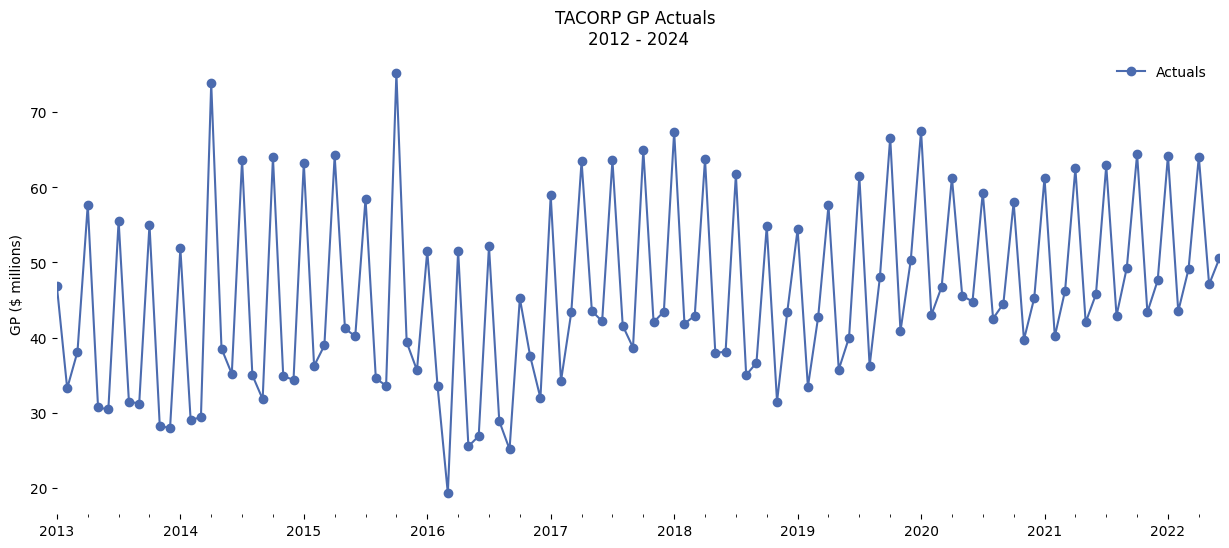

In [10]:
actuals_df2 = actuals_df.copy()
actuals_df2 = actuals_df2.set_index('ds')

year_begin = actuals_df2.index.year[0].astype(str)
year_end = actuals_df2.index.year[-1].astype(str)
    
title='TACORP GP Actuals \n' + year_begin + ' - ' + year_end
ylabel='GP ($ millions)'
xlabel=''
    
ax = actuals_df2['y'].plot(legend=True,figsize=(15,6),title=title,label='Actuals',marker='o',color='#4B6BAF')
    
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False);

#### Calculating Mean, Median, Mode, Min, Max, Standard Deviation, and Skew

In [11]:
mean = actuals_df2['y'].mean()
median = actuals_df2['y'].median()
mode = round(actuals_df2['y']).mode()[0].astype(int)
min = actuals_df2['y'].min()
max = actuals_df2['y'].max()
std = actuals_df2['y'].std()
skew = actuals_df2['y'].skew()

ct_data = [{'Mean': round(mean), 'Median': round(median), 'Min': round(min), 'Max': round(max), 'Mode': round(mode), 'Std': round(std), 'Skew': skew}] 
ct_df = pd.DataFrame(ct_data)
#ct_df = ct_df.style.set_properties(**{'text-align': 'center'}).hide_index()

#### Plotting Central Tendency

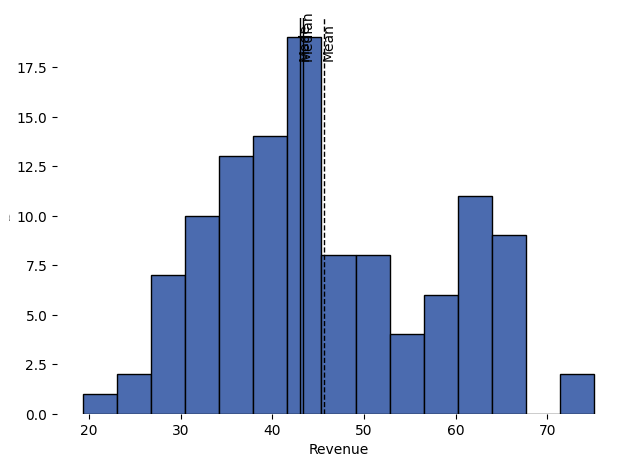

,Mean,Median,Min,Max,Mode,Std,Skew
0,46,43,19,75,43,12,0.360148


In [12]:
ax = plt.subplot(frameon=False)
ax.hist(actuals_df2['y'], bins = 15, color = '#4B6BAF', edgecolor = 'black')
ax.set_xlabel('Revenue', size = 10)
ax.set_ylabel('Frequency', size= 1) 
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
plt.axvline(median, color='k', linestyle='solid', linewidth=1)
plt.axvline(mode, color='k', linestyle='solid', linewidth=1)
plt.text(median-.25,18,'Median',rotation=90)
plt.text(mean-.25,18,'Mean',rotation=90)
plt.text(mode-.25,18,'Mode',rotation=90)
plt.tight_layout()
plt.show();
ct_df

Understanding central tendency is important to any times series analysis, as it gives the user a first look at the data's shape and behavior.

### Normalize Data Using Measures of Central Tendency

Many datasets tend to have missing data and/or statistical outliers that can increase error and skew model results.  By calculating measures of central tendency like mean, median, and mode, we can learn more about the data we are working with and potentially replace those outliers and/or missing values with a value like mean, which can ultimately reduce our error.  Unlike many other models, Prophet also accepts replacing outliers with "None".

In [13]:
actuals_df['moving_average'] = actuals_df.rolling(window=26, min_periods=1, center=True, on='ds')['y'].mean()
actuals_df['std_dev'] = actuals_df.rolling(window=26, min_periods=1, center=True, on='ds')['y'].std()
actuals_df['lower'] = actuals_df['moving_average'] - 1.645 * actuals_df['std_dev']
actuals_df['upper'] = actuals_df['moving_average'] + 1.645 * actuals_df['std_dev']

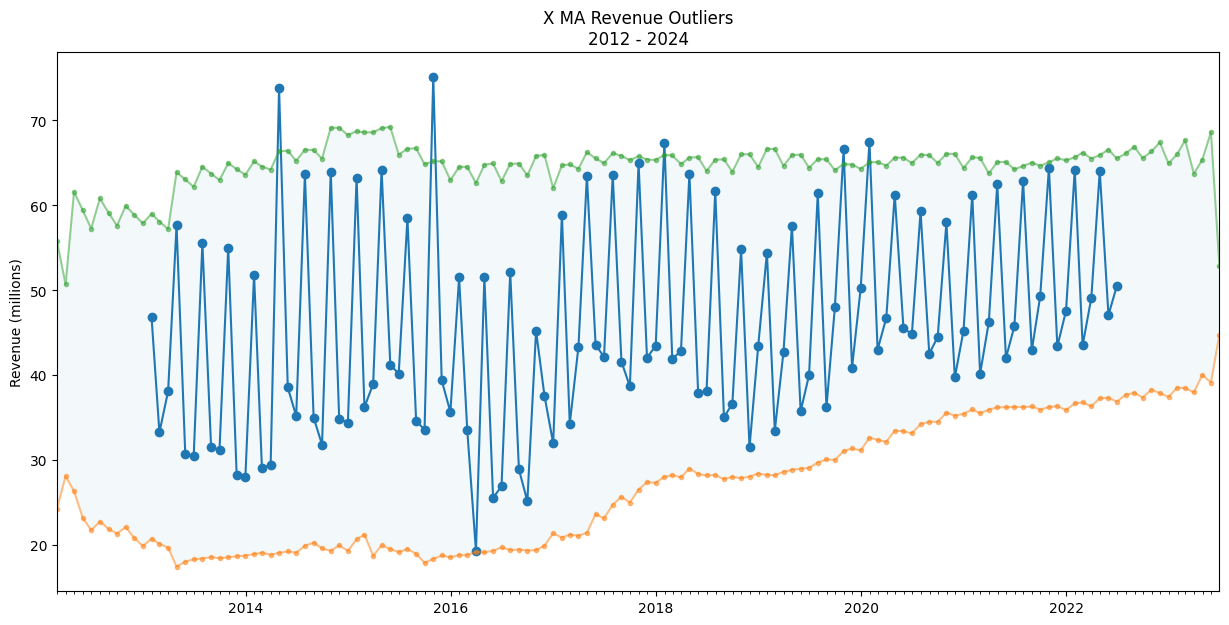

In [14]:
actuals_df2 = actuals_df.copy()
actuals_df2['ds'] = pd.to_datetime(actuals_df2['ds'])

fig, ax1 = plt.subplots(figsize=(15, 7))

actuals_df2 = actuals_df2.set_index('ds')
year_begin = str(actuals_df2.index.year[0])
year_end = str(actuals_df2.index.year[-1])

title = f'X MA Revenue Outliers\n{year_begin} - {year_end}'
ax1.set_title(title)
ax1.set_ylabel('Revenue (millions)')

ax1.plot(actuals_df2.index, actuals_df2['y'], marker='o')
ax1.plot(actuals_df2.index, actuals_df2['lower'], alpha=0.5, marker='.')
ax1.plot(actuals_df2.index, actuals_df2['upper'], alpha=0.5, marker='.')
ax1.fill_between(
    actuals_df2.index,
    actuals_df2['lower'],
    actuals_df2['upper'],
    where=(actuals_df2['lower'] < actuals_df2['upper']),
    alpha=0.05
)

ax1.autoscale(axis='x', tight=True)

months = mdates.MonthLocator()
ax1.xaxis.set_minor_locator(months)

plt.show()


#### Normalizing Data

The following line assigns None values to all actuals that fall outside pink margin of error above.  Once the outliers are removed, we can begin modeling.

In [15]:
actuals_df.loc[((actuals_df['y'] > actuals_df['upper']) | (actuals_df['y'] < actuals_df['lower'])), 'y'] = None

### 3 Rounds of Modeling

To make things interesting, I have created 3 rounds of modeling: the first, fits the model with no regressors or custom seasonality.  The second, uses the hw regressor but has no custom seasonality.  The third, has both the hw regressor and the custom 26-month seasonality incorporated.

#### Round 1

After normalization, Without tuning any paremeters

In [16]:
model = Prophet()
model.fit(actuals_df)
future_df = model.make_future_dataframe(periods=0,freq='ME')
forecast = model.predict(future_df)

16:26:31 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing


Text about this function that makes a compare table

In [17]:
def compare(actuals_df,forecast_df):
    
    actuals  = actuals_df[['ds','y']][:-(months_out-1)].set_index('ds',drop=True)
    forecast = forecast_df[['ds','yhat']][:-(months_out-1)].set_index('ds',drop=True)
    compare  = pd.concat([actuals, forecast], axis=1)
    compare.columns = ['Actuals','Forecast']    
    
    year_begin = compare.index.year[0].astype(str)
    year_end = compare.index.year[-1].astype(str)
    
    title='X MA Actuals vs. Forecasted Revenue \n' + year_begin + ' - ' + year_end
    ylabel='Revenue (millions)'
    xlabel=''
    
    ax = compare['Actuals'].plot(legend=True,figsize=(15,6),title=title,label='Actuals',marker='o',color='#4B6BAF')
    ax2 = compare['Forecast'].plot(legend=True, label='Forecast',marker='o',color='#FF0066')
    
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(frameon=False);
    
    return compare

,Actuals,Forecast
ds,,
2022-01-31,64.201651,63.628358
2022-02-28,43.490665,43.269492
2022-03-31,49.092953,46.404541
2022-04-30,64.041966,66.747202
2022-05-31,47.060985,45.380107
2022-06-30,50.527594,46.096014


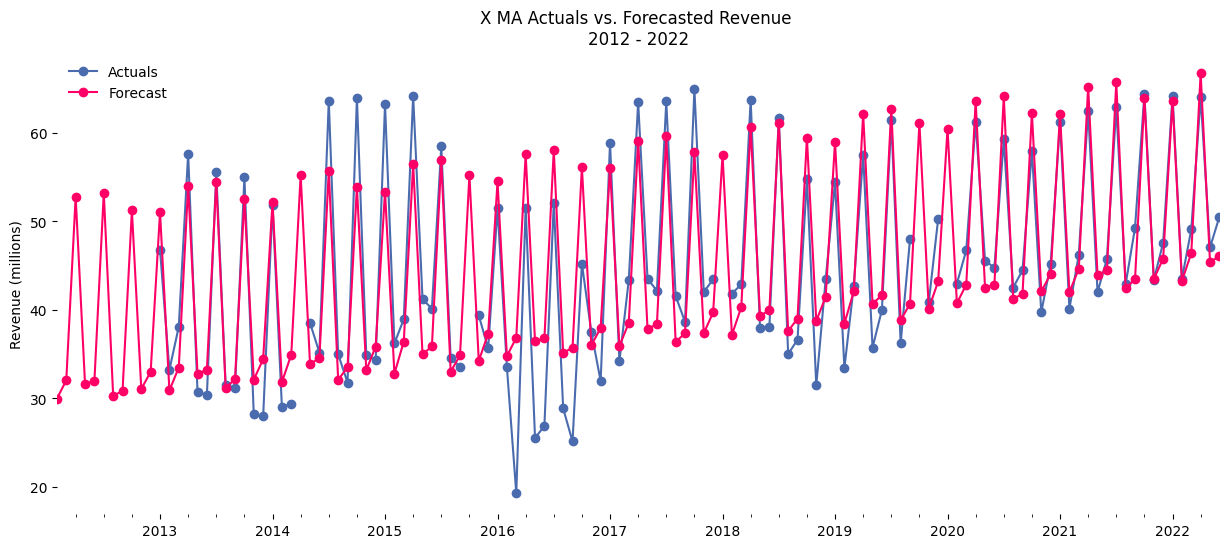

In [18]:
compare(actuals_df,forecast).tail(6)

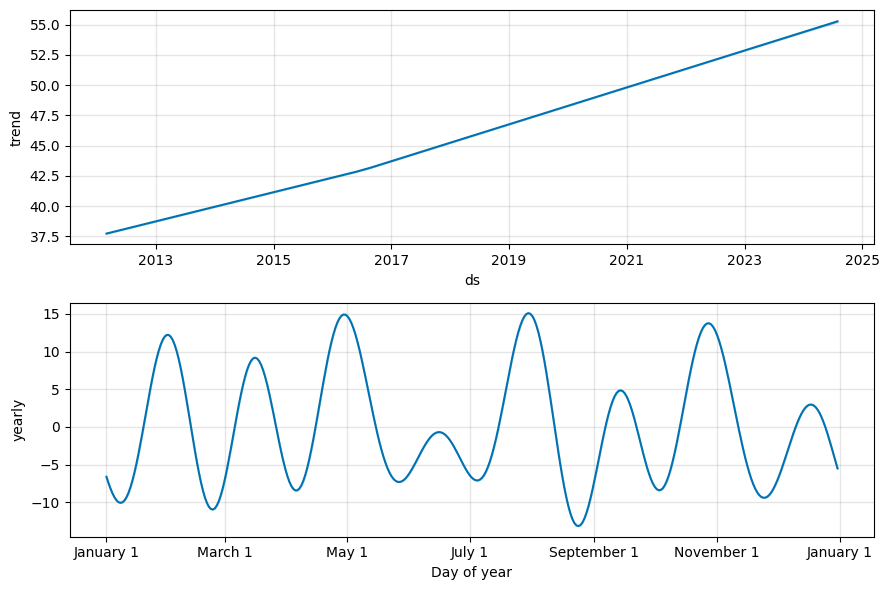

In [19]:
model.plot_components(forecast);

In [20]:
def accuracy(model,months_out):
    
    cv_df = cross_validation(model, horizon  = str(30.4167*months_out) + ' days'
                                  , period   = str(30.4167) + ' days'
                                  , parallel ='processes')
    pm_df = performance_metrics(cv_df)
    
    pm_df['accuracy'] = (1 - pm_df['mape']).round(3)
    pm_df['days out'] = pm_df['horizon']
    pm_df['months out'] = pm_df['months out'] = (((pm_df['horizon'].astype(str).str[:3].str.strip().str.replace(' d','').astype(int))/30).round(3)).astype(str)
    pm_df['months out'] = pm_df['months out'].astype(float).astype(int)
    pm_df['Forecast Model'] = 'X MA'
    pm_df = pm_df[['Forecast Model', 'days out', 'months out', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'coverage','accuracy']]
    pm_df.columns = ['Forecast Model', 'Days Out', 'Months Out', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MDAPE', 'Coverage', 'Accuracy']
    
    return pm_df.groupby(['Forecast Model','Months Out'], as_index=False).mean()

In [21]:
accuracy_results1 = accuracy(model,months_out);
accuracy_results1.head(10)

16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1]

,Forecast Model,Months Out,Days Out,MSE,RMSE,MAE,MAPE,MDAPE,Coverage,Accuracy
0,X MA,3,91 days 16:31:24.240000,43.286126,6.578917,5.719490,0.119618,0.104475,0.636364,0.880500
1,X MA,4,121 days 23:16:25.320000,39.154306,6.255450,5.550581,0.114849,0.104626,0.653409,0.885250
2,X MA,5,152 days 10:01:24.960000,38.475369,6.202661,5.444696,0.111356,0.107791,0.625000,0.888625
3,X MA,6,182 days 22:41:26.400000,36.195605,6.015217,5.201022,0.105955,0.110085,0.626263,0.894000
4,X MA,7,213 days 12:01:26.400000,32.867767,5.731006,4.958470,0.101563,0.106879,0.671717,0.898444
5,X MA,8,244 days 01:21:26.400000,29.074568,5.389207,4.704797,0.096639,0.105280,0.712121,0.903333
6,X MA,9,274 days 17:21:26.400000,25.557830,5.049690,4.492441,0.093717,0.104778,0.757576,0.906222
7,X MA,10,305 days 01:21:26.400000,21.885920,4.674300,4.117763,0.086691,0.098616,0.813131,0.913333
8,X MA,11,335 days 12:01:26.400000,19.261488,4.383830,3.739427,0.078914,0.078780,0.843434,0.921222
9,X MA,12,365 days 20:01:26.400000,16.767130,4.089809,3.422385,0.072547,0.057481,0.858586,0.927444


So, not bad for the first round.  The fit isn't great but we still are able to hover around a 90% accuracy, which is an average of multiple lines with the same months out count.

#### Round 2

In [22]:
model = Prophet()
model.add_regressor('hw')
model.fit(actuals_df)
future_df = actuals_df[['ds','hw']]
forecast = model.predict(future_df)

16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing


,Actuals,Forecast
ds,,
2022-01-31,64.201651,68.391532
2022-02-28,43.490665,43.276561
2022-03-31,49.092953,46.379727
2022-04-30,64.041966,67.199239
2022-05-31,47.060985,46.240400
2022-06-30,50.527594,46.070137


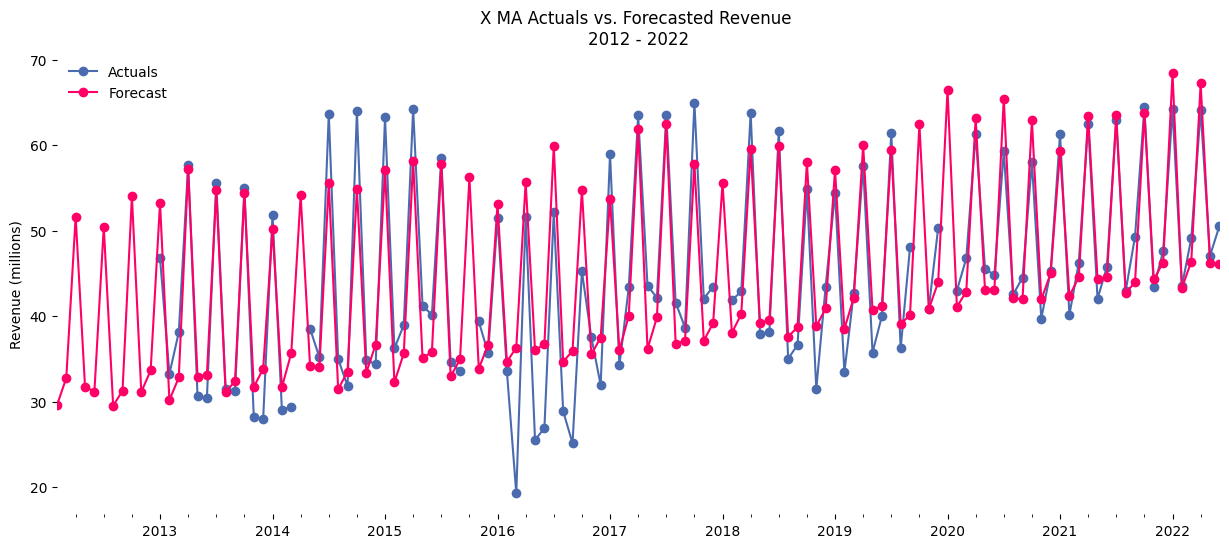

In [23]:
compare(actuals_df,forecast).tail(6)

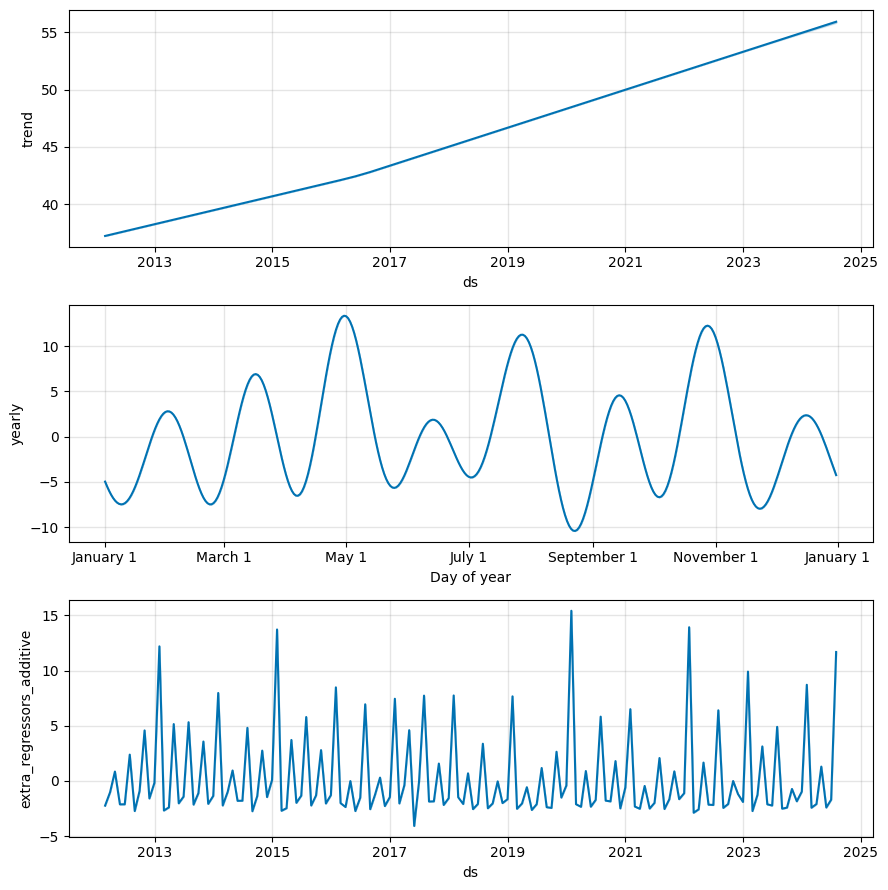

In [24]:
model.plot_components(forecast);

In [25]:
accuracy_results2 = accuracy(model,months_out)
accuracy_results2.head(12)

16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1]

,Forecast Model,Months Out,Days Out,MSE,RMSE,MAE,MAPE,MDAPE,Coverage,Accuracy
0,X MA,3,91 days 16:31:24.240000,31.660227,5.626439,4.456340,0.092346,0.052884,0.636364,0.907750
1,X MA,4,121 days 23:16:25.320000,27.226056,5.214482,4.277462,0.087464,0.059049,0.653409,0.912375
2,X MA,5,152 days 10:01:24.960000,28.045509,5.295437,4.439699,0.090059,0.072817,0.625000,0.909875
3,X MA,6,182 days 22:41:26.400000,28.050052,5.294838,4.520097,0.091845,0.075053,0.606061,0.908111
4,X MA,7,213 days 12:01:26.400000,27.308210,5.223586,4.577858,0.093595,0.078755,0.626263,0.906444
5,X MA,8,244 days 01:21:26.400000,25.345677,5.032498,4.537770,0.093037,0.081068,0.666667,0.907000
6,X MA,9,274 days 17:21:26.400000,21.976771,4.684113,4.328670,0.089900,0.080104,0.722222,0.910333
7,X MA,10,305 days 01:21:26.400000,18.981628,4.354045,4.042088,0.084711,0.078664,0.767677,0.915222
8,X MA,11,335 days 12:01:26.400000,17.393575,4.167526,3.814337,0.080305,0.072505,0.777778,0.919778
9,X MA,12,365 days 20:01:26.400000,15.117329,3.883400,3.460043,0.073670,0.068464,0.813131,0.926222


Round 2 was a little bit better.  We went from 90% to about roughly 92% due to the regressor, which was able to hit on historically high and low sales months.  However, the numbers are inconsistent.  We would expect to see a slow predictable decline in accuracy over time.  In this case, 90 - 93% creates a range of variance that raises eyebrows.

#### Round 3

In [26]:
model = Prophet(yearly_seasonality=4)
model.add_seasonality(name='2-Year Z Cycle',
                      period= (26/12) * 365.25,
                      fourier_order=4)
model.add_regressor('hw')
model.fit(actuals_df)
future_df = actuals_df[['ds','hw']]
forecast = model.predict(future_df)

16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing


,Actuals,Forecast
ds,,
2022-01-31,64.201651,67.930868
2022-02-28,43.490665,44.251763
2022-03-31,49.092953,47.458833
2022-04-30,64.041966,68.481118
2022-05-31,47.060985,47.629368
2022-06-30,50.527594,47.860605


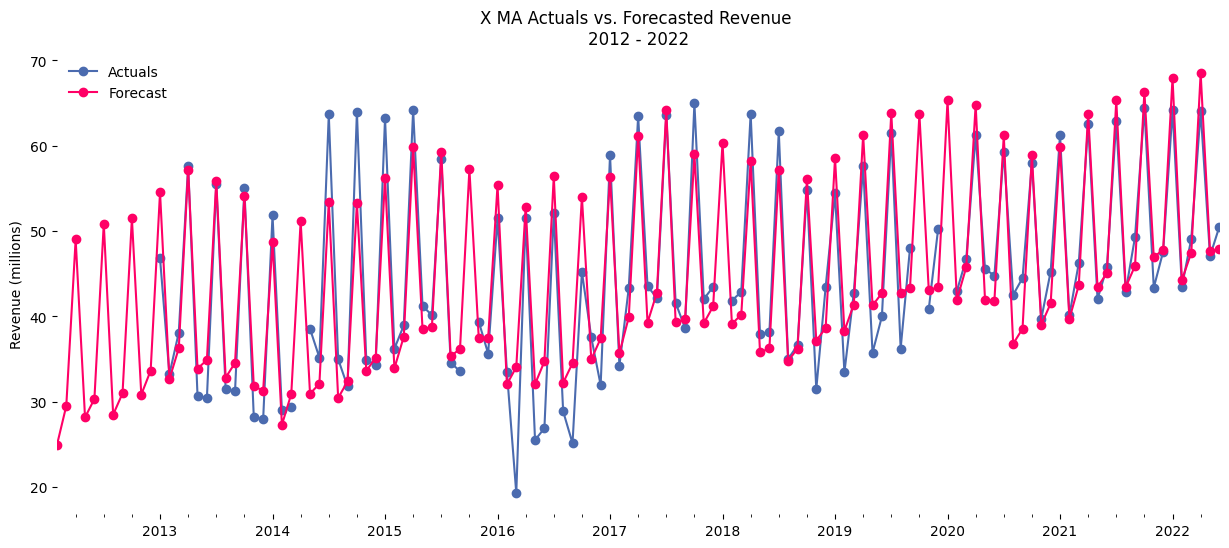

In [27]:
compare(actuals_df,forecast).tail(6)

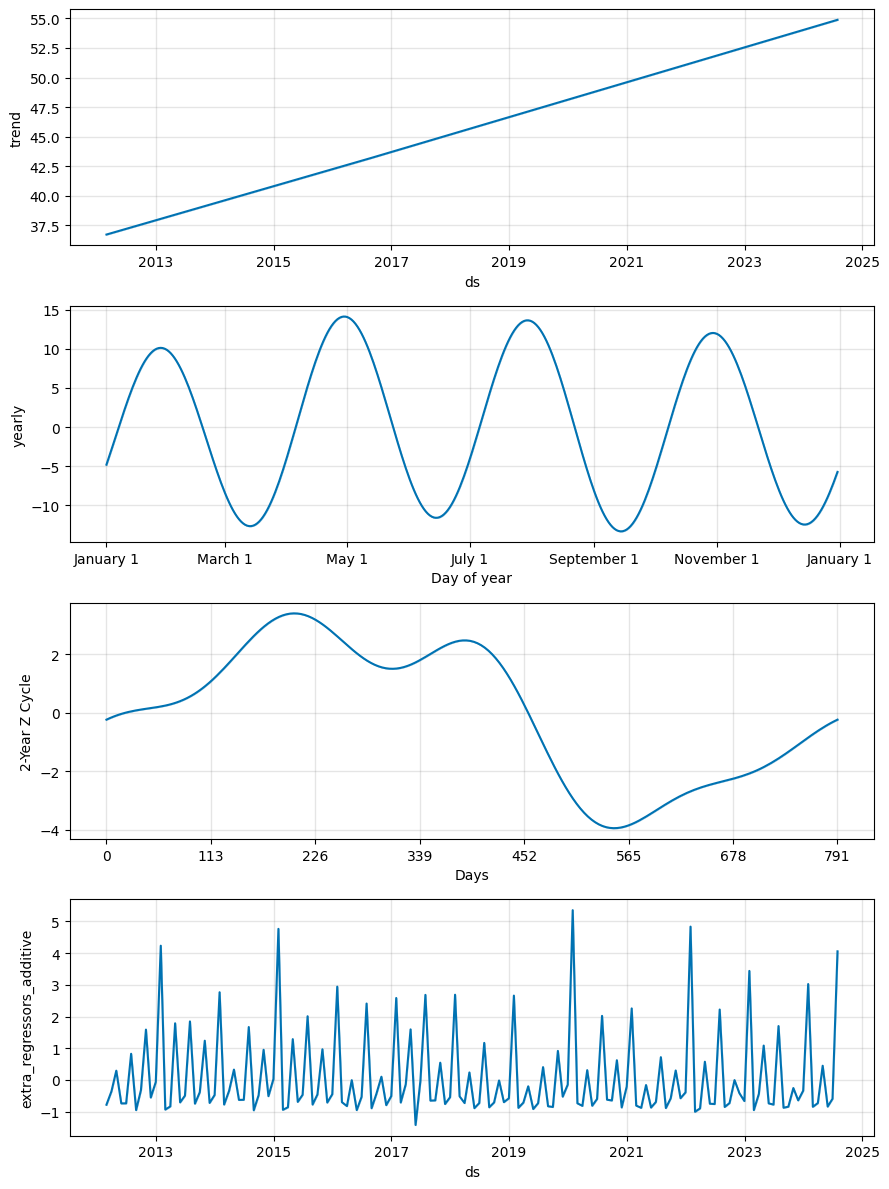

In [28]:
model.plot_components(forecast);

In [29]:
accuracy_results3 = accuracy(model,months_out)
accuracy_results3.head(12)

16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1]

,Forecast Model,Months Out,Days Out,MSE,RMSE,MAE,MAPE,MDAPE,Coverage,Accuracy
0,X MA,3,91 days 16:31:24.240000,24.465041,4.944052,4.117951,0.084895,0.083840,0.795455,0.915250
1,X MA,4,121 days 23:16:25.320000,22.914311,4.785110,3.997872,0.082069,0.082894,0.772727,0.918000
2,X MA,5,152 days 10:01:24.960000,23.847003,4.881238,4.025128,0.083806,0.082253,0.727273,0.916375
3,X MA,6,182 days 22:41:26.400000,26.209748,5.116724,4.187317,0.088912,0.084176,0.696970,0.911111
4,X MA,7,213 days 12:01:26.400000,26.861236,5.180108,4.227733,0.091100,0.084062,0.717172,0.908889
5,X MA,8,244 days 01:21:26.400000,26.941080,5.188148,4.195908,0.090685,0.083777,0.707071,0.909333
6,X MA,9,274 days 17:21:26.400000,26.930238,5.186882,4.172176,0.091611,0.088175,0.727273,0.908444
7,X MA,10,305 days 01:21:26.400000,25.561814,5.053642,3.948617,0.087744,0.080988,0.722222,0.912222
8,X MA,11,335 days 12:01:26.400000,23.167480,4.810946,3.624067,0.080807,0.040899,0.727273,0.919111
9,X MA,12,365 days 20:01:26.400000,21.499558,4.632289,3.463998,0.076883,0.037025,0.742424,0.923111


Round 3 by far yielded the best results so far.  By incorporating custom seasonality, the hw regressor, and a few tuning parameteres like Fourier Order, we were able to achieve a consistent 93%.  Now that we have a winning model, we can forecast into the future.

## 5. Forecast

Once we are confident in our test, train, split results, the model is now fit to the entire dataset and a forecast in created that now goes beyond the test set by the number of months out we specified at the beginning of the notebook.  Notice how the .fit function now contains our original df instead of the training set.

In [30]:
model = Prophet(yearly_seasonality=4)
model.add_seasonality(name='2-Year Z Cycle',
                      period= (26/12) * 365.25,
                      fourier_order=4)
model.add_regressor('hw')
model.fit(actuals_df)
future_df = actuals_df[['ds','hw']]
#future_df = model.make_future_dataframe(periods=0,freq='M')
forecast = model.predict(future_df)

16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
actuals_df3 = actuals_df.copy()
forecast3 = forecast.copy()

actuals_df3['ds'] = pd.to_datetime(actuals_df3['ds'])
forecast3['ds'] = pd.to_datetime(forecast3['ds'])

cut = -35 + months_out  # your existing logic

actuals_df3 = actuals_df3[['ds','y']][:cut].set_index('ds', drop=True)
forecast3   = forecast3[['ds','yhat']][:cut].set_index('ds', drop=True)

compare3 = pd.concat([actuals_df3, forecast3], axis=1).reset_index(drop=False)
compare3 = compare3[['ds','y','yhat']]
compare3.columns = ['Date','Actuals','Forecast']

compare3['Year'] = compare3['Date'].dt.year.astype(str)
compare3['Quarter'] = compare3['Date'].dt.quarter.astype(str)
compare3['Period'] = compare3['Quarter'] + 'Q' + compare3['Year'].str[-2:]

# ✅ only sum numeric cols
compare3 = compare3.groupby(['Year','Quarter','Period'], as_index=False)[['Actuals','Forecast']].sum()

compare3 = compare3[['Period','Actuals','Forecast']]


In [32]:
forecast['product_cycle'] = forecast['2-Year Z Cycle'] + forecast['trend']

,Period,Actuals,Forecast
36,1Q21,147.647387,143.187738
37,2Q21,150.277158,152.266265
38,3Q21,155.071503,154.632305
39,4Q21,155.357732,161.065536
40,1Q22,156.785269,159.641464
41,2Q22,161.630545,163.971091
42,3Q22,0.000000,151.209936
43,4Q22,0.000000,144.938296
44,1Q23,0.000000,150.936291
45,2Q23,0.000000,159.666161


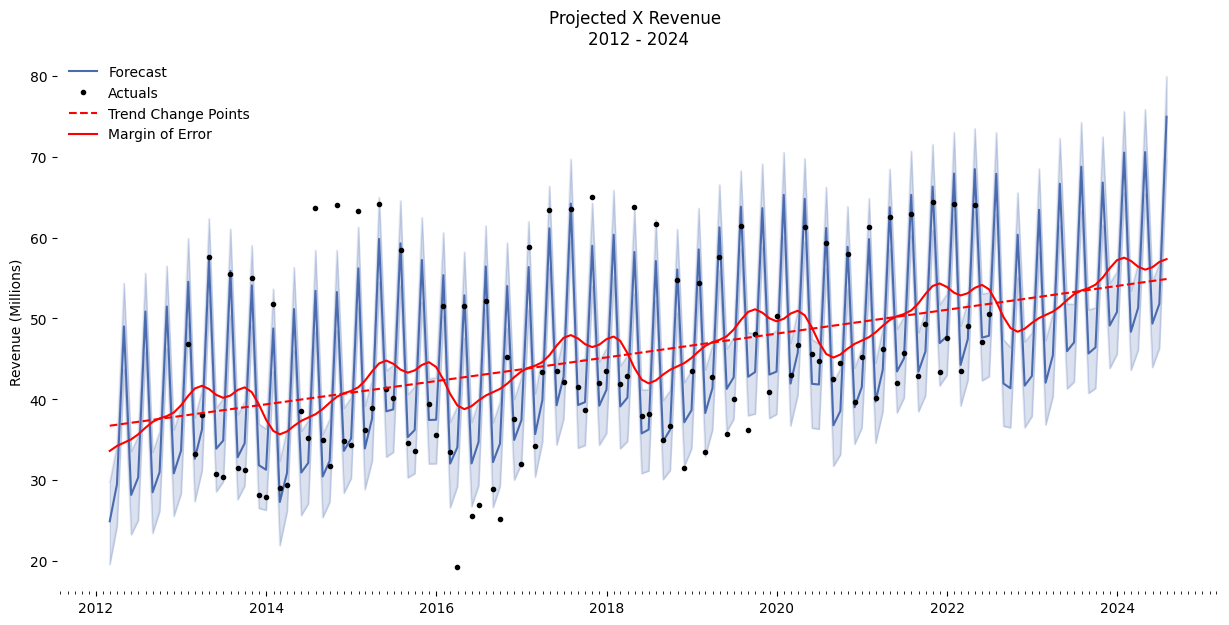

In [33]:
x = np.array(forecast['ds'])
x2 = np.array(actuals_df['ds'])
actuals = actuals_df['y']
y_lower = np.array(forecast['yhat_lower'])
y_upper = np.array(forecast['yhat_upper'])
y_hat = forecast['yhat']
trend = forecast['trend']
product_cycle = forecast['2-Year Z Cycle'] + forecast['trend']

fig, ax1 = plt.subplots(figsize=(15,7))

year_begin = forecast.set_index('ds').index.year[0].astype(str)
year_end = forecast.set_index('ds').index.year[-1].astype(str)
    
title='Projected X Revenue \n' + year_begin + ' - ' + year_end

ax1.set_title(title)
ax1.set(ylabel='Revenue (Millions)')
ax1.plot(x, y_lower, color='#4B6BAF' ,alpha=0.1,label='_nolegend_')
ax1.plot(x, y_upper, color='#4B6BAF', alpha=0.1, label='_nolegend_')
ax1.plot(x, y_hat, color='#4B6BAF', alpha=None)
ax1.plot(x2, actuals, '.',color='black')
ax1.plot(x, trend, '--',color='red')
ax1.plot(x2, product_cycle, '-',color='red')
ax1.fill_between(x, y_lower, y_upper, where=(y_lower < y_upper), color='#4B6BAF', alpha=0.2)
 
ax1.legend(['Forecast','Actuals','Trend Change Points','Margin of Error'],frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.autoscale(axis='ds',tight=True)

months = mdates.MonthLocator()
ax1.xaxis.set_minor_locator(months);

compare3.tail(12)

## 6. Format & Export Results to CSV

#### Format Forecast & Accuracy DataFrames

Here we format the forecast dataframe to have year, quarter, month, geo, and platform column so we can reference them in the TSS WW excel revenue model via a SUMIFS function. Finally, the forecast_df.to_csv function exports that table to our Box folder destination as a csv file.

In [34]:
forecast_df = forecast[['ds','trend','product_cycle','yhat_lower','yhat_upper','yhat']]

In [35]:
pd.options.mode.chained_assignment = None
forecast_df['Year'] = forecast_df['ds'].dt.year
forecast_df['Month'] = forecast_df['ds'].dt.month
forecast_df['Quarter'] = forecast_df['ds'].dt.quarter
forecast_df['Product'] = 'X'
forecast_df['Geo'] = 'WW'

In [36]:
forecast_df['Quarter'] = forecast_df['Quarter'].astype(str)
forecast_df['Quarter'] = "Q" + forecast_df['Quarter']

In [37]:
forecast_df = forecast_df[['ds','Year','Quarter','Month','Geo','Product','trend','product_cycle','yhat_lower','yhat_upper','yhat']]
forecast_df.columns = ['Date','Year','Quarter','Month','Geo','Product','Trend','Product Cycle','Lower Margin','Upper Margin','Revenue']

In [38]:
accuracy_df = accuracy_results3[['Forecast Model', 'Months Out', 'MSE', 'RMSE', 'MAE', 'MAPE','MDAPE', 'Coverage', 'Accuracy']]

#### Export Test Data (Accuracy) to CSV

In [39]:
forecast_df.to_csv('x_forecast.csv', index=False)

In [40]:
accuracy_df.to_csv('x_accuracy.csv', index=False)